Коррекция сферических расхождений с использованием скорости однократных отражений.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')

from seismicpro.batchflow import Dataset
from seismicpro.src import (SeismicBatch, SegyFilesIndex, FieldIndex, TraceIndex,
                            seismic_plot, spectrum_plot, merge_segy_files, KNNIndex)

from utils import draw_gain

plt.style.use('ggplot')
path_raw = '/Users/anton/work/geolog/raw_data/2_Egor_TAR/P00_raw.sgy'

field_index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw))
field_index.head()

,offset,TraceNumber,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw
FieldRecord,,,,
2020,549,285,1,/Users/anton/work/geolog/raw_data/2_Egor_TAR/P...
2020,-555,286,2,/Users/anton/work/geolog/raw_data/2_Egor_TAR/P...
2020,564,284,3,/Users/anton/work/geolog/raw_data/2_Egor_TAR/P...
2020,-583,287,4,/Users/anton/work/geolog/raw_data/2_Egor_TAR/P...
2020,600,283,5,/Users/anton/work/geolog/raw_data/2_Egor_TAR/P...


In [2]:
batch = (Dataset(field_index, SeismicBatch).next_batch(500)
         .load(fmt='segy', components='raw', tslice=slice(3000))
)

Будем смотреть как происходит коррекция сферических расхождений на кропе филда и на целом филде.

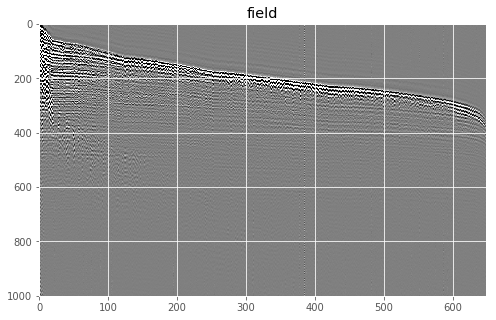

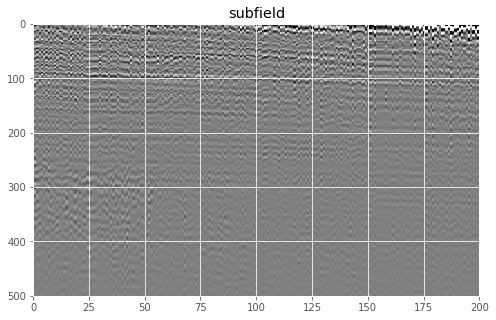

In [3]:
sample = batch.raw[21]

cv = 0.1
subsample = sample[100:300, 200:700]
seismic_plot(sample*10000, figsize=(8, 5), names='field',
             vmin=-cv, vmax=cv, cmap='gray', )
seismic_plot(subsample*10000, figsize=(8, 5), names='subfield',
             vmin=-cv, vmax=cv, cmap='gray')

Время берем пока что стандартное, из софта для геологии

In [4]:
speed = np.array([1524]*700 + [1924.5]*300 + [2184.0]*400 +  [2339.6]*400 + 
                 [2676]*150 + [2889.5] * 2250 + [3566] * 2800 + [4785.3] * 1000)

Для коррекции сферических расхождений, значения амплитуд в контретное значение времени домножается на растущую функцию коррекции затухания $g(t)$.
$$A(t) = A(t) * g(t)$$
Для слоистого разреза затухание амплитуд может быть приблизительно описана следующей формулой:
$$g(t) = \frac{t^{pow_t} * V_{rms}^{pow_v}(t)}{V_0}$$
Где,
* $V_{rms}$ - среднеквадратическая скорость однократных отражений.
* $t$ - полное время пробега
* $V_0$ - начальное значение скорости.

$pow_t$ и $pow_v$ настраиваемые параметры.

In [5]:
def calc_v_rms(t, speed):
    if t == 0:
        return speed[0]
    return (np.mean(speed[:t]**2))**.5

def time_g(time, speed, t_pow, v_pow):
    correction = (calc_v_rms(time, speed) ** v_pow * time** t_pow)/speed[0]
    if correction == 0:
        return 1.
    return correction

In [6]:
speed_sample = speed[:sample.shape[1]]
def time_dep(trace, speed, time, v_pow=2, t_pow=1):
    speed = speed[: trace.shape[1]]
    new_trace = np.zeros_like(trace)
    
    for ix, t in enumerate(time):
        timestamp = trace[:, ix]
        new_trace[:, ix] = timestamp * time_g(t, speed, v_pow, t_pow)
    return new_trace

Посмотрим как пройдет корректировка кропа

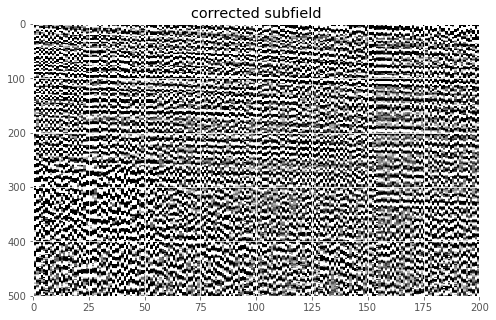

In [24]:
time = np.arange(200, 700)
correct_sub = time_dep(subsample, speed, time, 2., 1)

seismic_plot(correct_sub, figsize=(8, 5), names='corrected subfield',
             vmin=-cv, vmax=cv, cmap='gray')

Для проверки качества работы алгоритма рисуется функция сглаженных значений амплитуды в зависимости от времени в децибелах.

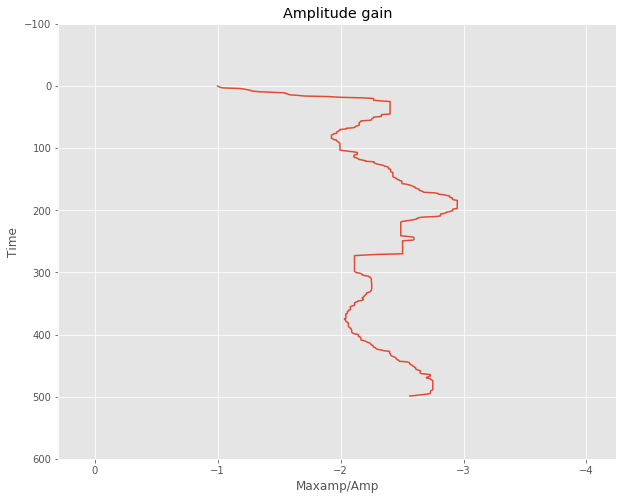

In [23]:
draw_gain(correct_sub, 51)

И для полного филда

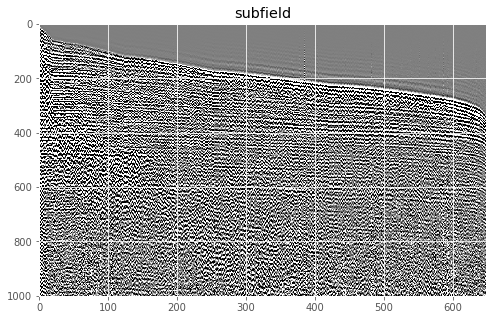

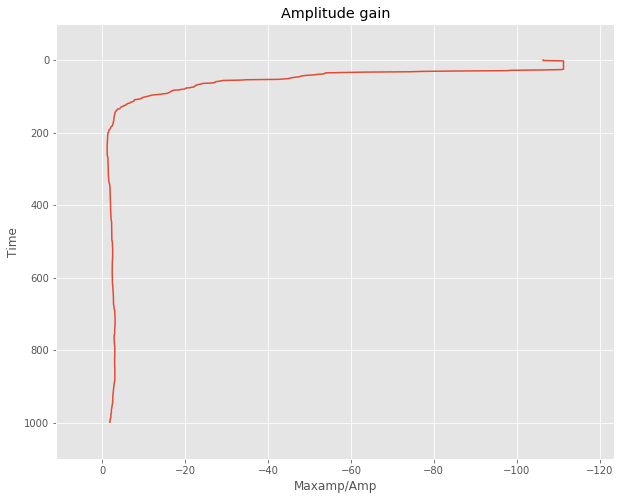

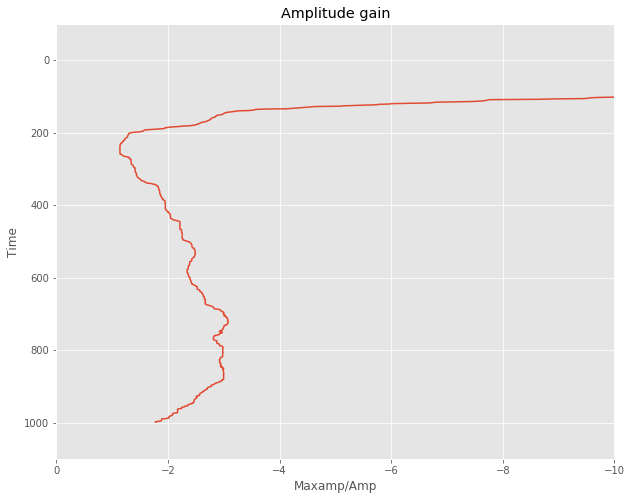

In [21]:
correct_field = time_dep(sample, speed, range(0, 1000), 2)
seismic_plot(correct_field, figsize=(8, 5), names='subfield',
             vmin=-cv, vmax=cv, cmap='gray')
draw_gain(correct_field, 51)
draw_gain(correct_field, 51, (0, -10))

Видно, что и для кропа и для филда функция восстановления коррекции работает хорошо.

TODO: автоматически подбирать коэфициенты pow_t и pow_v